# Shumovskaia Valentina, assignment #1

# Problem 1

**Capacitated facility location**

You need to solve a *capacitated facility location* problem. There are a number of clients that can be served by a number of potential facilities. As in the case of a common (uncapacitated) facility location problem, you need to decide which facilities to open (paying the opening cost for each) and which clients to serve at each facility (paying the assignment cost). Each client must be assigned to one opened facility. In addition, you have a cap on how many clients each facility can serve. As usual, you want to minimize the costs.

Implement the following algorithms and investigate them. Use the below code to generate the data, and to visualize the results. You are supposed to play with different configurations and problem sizes. Please make your report detailed (otherwise lower amount of points than indicated may be assigned).

* (2 points). Implement a **greedy algorithm** for the problem.
* (3 points). Implement **some local optimization algorithm**. Try to design powerful moves that are at the same time easy to search through. **Important:** your move should connect the whole domain, i.e. for any pair of feasible solutions, there should exist a sequence of moves from the family you design that transform one solution to the other.
* (3 points). Implement the **simulated annealing algorithm** based on the best of your local optimization algorithms. Play with the schedule and see how it affects the results. Compare with the local optimization algorithm that you base upon. Note, that if implemented correctly, simulated annealing should improve over the local optimization algorithm.

Below is the Gurobi solution that uses a mixed-integer solver (we will come to that in week 3). You can use it as a reference for small instances (for which it will give you a global optimum), and also reuse the visualization code.

Before writing your code, study the cells below to learn variables, convention for the solution format etc.

In [1]:
import numpy as np
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import cycle
from gurobipy import GRB
import gurobipy as grb

%matplotlib inline

class Problem:
    def __init__(self, C=20, F=15):
        self.C = C
        self.F = F
        
        self.clients = np.random.rand(2, C)    # client positions
        self.facilities = np.random.rand(2, F) # facility positions

        # maximum number of clients per facility
        self.capacities = np.ones((F,), dtype=np.int32)*4;

        # assignment cost is defined as the squared distance between a client and a facility
        dx = \
            np.matlib.repmat(self.clients[0,:],F,1) - \
            np.matlib.repmat(self.facilities[0,:],C,1).transpose();
        dy = \
            np.matlib.repmat(self.clients[1,:],F,1) - \
            np.matlib.repmat(self.facilities[1,:],C,1).transpose();

        self.assignment_costs = 3*(dx*dx + dy*dy);

        self.opening_costs = np.ones((F,));
    
    def assign_random_capacities(self):
        """
        Assign more or less random capacities to facilities.
        
        This is one of the possible ways to change the problem configuration.
        In other words, use this function when testing your solution!
        """
        while True:
            self.capacities = \
                np.random.randint(2*self.C // self.F, size=self.F) + 1
            if sum(self.capacities) > self.C * 1.3:
                break
    
    def assign_random_opening_costs(self):
        """
        Assign more or less random opening costs to facilities.
        
        Same as above -- use this for your report.
        """
        # could be float, but let it be simple
        self.opening_costs = \
            np.random.randint((self.C+self.F-1) // self.F, size=self.F) + 1
    
    def plot(self, y, assignments, fig=plt):
        """
        Plot the given solution (y, assignments)
        
        Arguments:
        y, assignments -- see Problem.objective().
        fig            -- an instance of matplotlib.axes._axes.Axes to draw on.
                          Also, can be matplotlib.pyplot, in this case use the default Axes.
                          This is useful to compare your results (see "Results comparison" section).
        """
        
        y = np.array(y)
        assignments = np.array(assignments)
        
        y = y.astype(np.int32)
        assignments = assignments.astype(np.int32)
        
        for cli,fac in enumerate(assignments):
            fig.plot([self.clients[0,cli], self.facilities[0,fac]], \
                     [self.clients[1,cli], self.facilities[1,fac]], c=(.7,.7,.7))
            
        fig.scatter(self.clients[0,:], self.clients[1,:], s=15.0, c=assignments, \
                    vmin=0, vmax=self.F-1)
        
        fig.scatter(self.facilities[0,:], self.facilities[1,:], s=54.0, \
                    c=range(self.F), linewidth = [1*el for el in y])
        
    def objective(self, y, assignments):
        """
        Return objective function value given a solution.
        If the solution is infeasible, return infinity.
        
        Arguments:
        y           -- a binary 1D array of size F. y[i] is 1 iff i-th facility is open.
        assignments -- an integer 1D array of size C. assignments[i] is index of facility
                       that i-th client is assigned to.
        """
        assert len(y) == self.F
        assert len(assignments) == self.C
        
        y = np.array(y)
        assignments = np.array(assignments)
        
        y = y.astype(np.int32)
        assignments = assignments.astype(np.int32)
        
        retval = sum(is_opened*opening_cost \
                     for is_opened, opening_cost in zip(y, self.opening_costs))
        
        assignment_counts = np.zeros_like(y)
        
        for cli,fac in enumerate(assignments):
            if not y[fac]:
                return np.inf
            else:
                retval += self.assignment_costs[fac,cli]
                assignment_counts[fac] += 1
                
        if any(assignment_counts > self.capacities):
            return np.inf
            
        return retval
        
    def solve_gurobi(self, verbose=False):
        """
        Solve the problem using mixed integer program solver.
        Return `y, assignments` (see Problem.objective() docstring for format).
        
        Arguments:
        verbose -- controls Gurobi output.
        """
        m = grb.Model("facility")

        y = []
        for i_f in range(self.F):
            y.append(m.addVar(vtype=GRB.BINARY))

        x = []    
        for i_f in range(self.F):
            x.append([])
            for i_c in range(self.C):
                x[i_f].append(m.addVar(vtype=GRB.BINARY))

        # the objective is to minimize the total fixed and variable costs
        m.modelSense = GRB.MINIMIZE

        # update model to integrate new variables
        m.update()

        # set optimization objective - minimize sum of fixed costs
        obj_summands = []
        for i_f in range(self.F):
            obj_summands.append(self.opening_costs[i_f]*y[i_f])

        for i_f in range(self.F):
            for i_c in range(self.C):
                obj_summands.append(self.assignment_costs[i_f][i_c]*x[i_f][i_c])

        m.setObjective(grb.quicksum(obj_summands))

        # set constraints
        for i_c in range(self.C):
            client_constr_summands = [x[i_f][i_c] for i_f in range(self.F)]
            m.addConstr(sum(client_constr_summands), GRB.EQUAL, 1.0)

        for i_f in range(self.F):        
            facility_constr_summands = [x[i_f][i_c] for i_c in range(self.C)]
            m.addConstr(sum(facility_constr_summands), \
                        GRB.LESS_EQUAL, self.capacities[i_f]*y[i_f])       

        for i_f in range(self.F):        
            for i_c in range(self.C):
                m.addConstr(x[i_f][i_c], GRB.LESS_EQUAL, y[i_f])

        # optimize
        m.setParam(GRB.Param.OutputFlag, verbose)
        m.optimize()
        
        facilities_opened = [y[i_f].X for i_f in range(self.F)]
        clients_assignment = \
            [i_f for i_c in range(self.C) for i_f in range(self.F) if x[i_f][i_c].X != 0]
        
        return facilities_opened, clients_assignment

In [2]:
def solve_random(self):
    open_idx = list(range(self.F))
    random.shuffle(open_idx)
    open_idx = open_idx[:self.F * 4 // 5] # open 80% of facilities
    
    y = np.zeros(self.F)
    y[open_idx] = 1
    
    assignments = np.empty(problem.C)
    for cli, fac in zip(range(problem.C), cycle(open_idx)):
        assignments[cli] = fac
    
    return y, assignments

Problem.solve_random = solve_random

In [4]:
def random_problem(seed, c=20, f=15):
    np.random.seed(seed)
    problem = Problem(C=c, F=f)
    problem.assign_random_capacities()
    problem.assign_random_opening_costs()
    return problem

The following example shows `Problem` class usage.

C = 20, F = 15


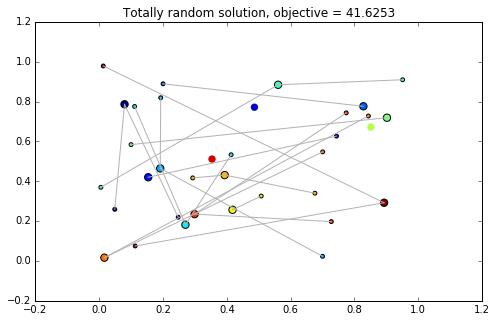

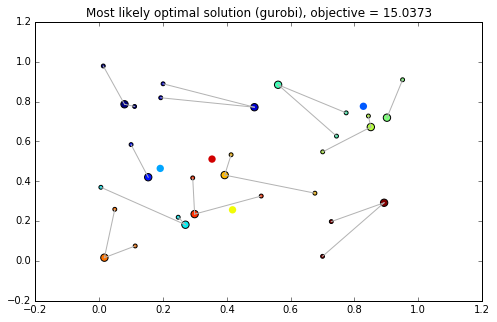

In [5]:
problem = random_problem(seed=666)
print('C = 20, F = 15')

# completely random solution
y, assignments = problem.solve_random()
problem.plot_solution(y, assignments, 'Totally random solution')

#gurobi solution
y, assignments = problem.solve_gurobi()
problem.plot_solution(y, assignments, 'Most likely optimal solution (gurobi)')

## Greedy algorithm

##### The main idea:

We want to minimize the following expression by opening and connecting facilities $f$ with clients $c$ (in other words, choosing vectors $y$ and $assignments$ which were described above in the code)

$\sum_{f}\big(opening\_cost\{f\}\cdot y[f] + \sum_{c}assignment\_cost\{f,c\}*Indicator\{assignment[c]=f\}\big)$

$number\_of\_clients\{f\} \leq capacity\{f\}$

##### How to make it greedy:

Let's minimize such expression on every step by choosing the best client $c$ and the best facility $f$, such that the following expression gets its minimum:

$opening\_cost\{f\}*Indicator\{f \textrm{ isn't opened}\} + assigmnent\_cost\{f,c\}$

We use there indicator <<$f$ isn't opened>> because if it's not opened, we need to spend money to open this particular facility.

For sure, we will control the number of clients in every facility.

In [6]:
def solve_greedy(self):
    y = np.empty(self.F, dtype=np.int32)
    assignments = np.empty(self.C, dtype=np.int32)
    
    # indicates if facility[index] is not opened one (then we do not need to pay additional money)
    if_closed = np.ones(self.F, dtype=np.int32) 
    # let's control the constraints using this variable
    num_of_clients = np.zeros(self.F, dtype=np.int32)
    clients = list(range(self.C))
    facilities = list(range(self.F))

    # on every step let us choose the best connection between client and facility while there are clients to connect
    while True:
        best_cost = -1
        best_facility = np.nan
        best_client = np.nan
        for i_c in clients:
            for i_f in facilities:
                # expression that we want to minimize
                current_cost = self.opening_costs[i_f]*if_closed[i_f] + self.assignment_costs[i_f][i_c]
                # best connection
                if (current_cost < best_cost) or (best_cost == -1):
                    best_cost = current_cost
                    best_facility = i_f
                    best_client = i_c
        
        if if_closed[best_facility] == 1:
            # we need to open the best facility if it's not
            if_closed[best_facility] = 0
        assignments[best_client] = best_facility
        num_of_clients[best_facility] = num_of_clients[best_facility] + 1
        
        # remove full facilities and connected clients from the loop
        if num_of_clients[best_facility] == self.capacities[best_facility]:
            facilities.remove(best_facility)
        clients.remove(best_client)
        if clients == []: #stop when everyone is connected
            break
            
    for i_f in range(self.F):
        if if_closed[i_f] == 0: # means that opened
            y[i_f] = 1
        else:
            y[i_f] = 0
    return y, assignments

Problem.solve_greedy = solve_greedy

Demonstration for several cases.

C = 20, F = 15


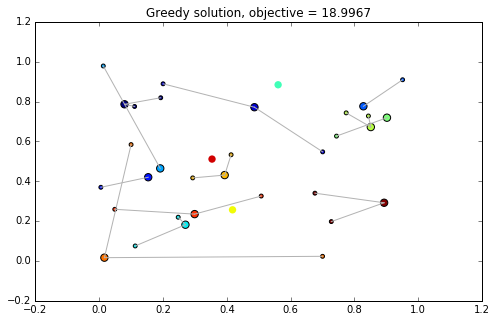

In [7]:
problem = random_problem(seed=666)
print('C = 20, F = 15')

y, assignments = problem.solve_greedy()
problem.plot_solution(y, assignments, 'Greedy solution')

C = 90, F = 10


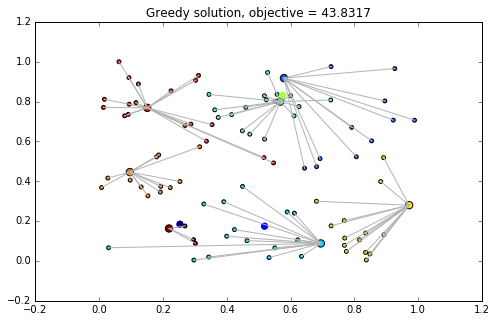

In [8]:
problem = random_problem(seed=777, c=90, f=10)
print('C = 90, F = 10')

y, assignments = problem.solve_greedy()
problem.plot_solution(y, assignments, 'Greedy solution')

C = 20, F = 20


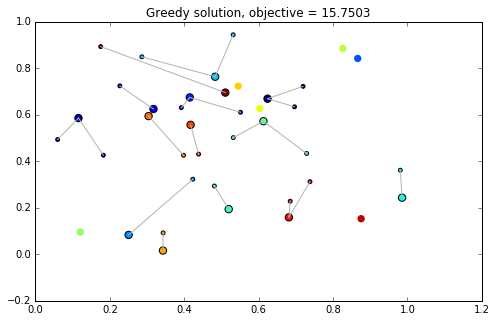

In [9]:
problem = random_problem(seed=123, c=20, f=20)
print('C = 20, F = 20')

y, assignments = problem.solve_greedy()
problem.plot_solution(y, assignments, 'Greedy solution')

## Local optimization algorithm

First, we should define what is the neighbour. In my case I decided to define it the following way: we randomly choose a client and a facility and connect them (under constraints).

Then we check if our functional got less, and if so, we accept our changes.

And so on (stop by iterations limit).

In [10]:
def get_neighbour(self, y, assignments):    
    # choose random client and random facility and connect them (if they're appropriate)
    y_new = deepcopy(y)
    assignments_new = deepcopy(assignments)
    
    appropriate = False
    c_rand = np.nan
    f_rand = np.nan

    #we should always check constraints
    while not appropriate:
        c_rand = random.randint(0, self.C - 1)
        f_rand = random.randint(0, self.F - 1)
        number_of_clients = sum([1 for i_c in range(self.C) if assignments[i_c] == f_rand])
        if number_of_clients < self.capacities[f_rand]:
            appropriate = True
    
    # number of clients in the new clients facility
    number_of_clients_new = sum([1 for i_c in range(self.C) if assignments[i_c] == f_rand]) + 1

    # number of clients in the old clients facility
    number_of_clients_old = sum([1 for i_c in range(self.C) if assignments[i_c] == assignments[c_rand]]) - 1
    f_old = assignments_new[c_rand]
    
    #change assignments
    assignments_new[c_rand] = f_rand
    
    # if previous facility became empty
    if number_of_clients_old == 0:
        y_new[f_old] = 0
    
    # if new facility was empty
    if number_of_clients_new - 1 == 0:
        y_new[f_rand] = 1
    
    return y_new, assignments_new

Problem.get_neighbour = get_neighbour

In [11]:
def solve_local_optimization(self):
    maxiter = 10000
    niter = 0
    # initial state (greedy)
    y, assignments = self.solve_greedy()    
    
    while (niter < maxiter):
        # get random appropriate neighbour
        y_new, assignments_new = self.get_neighbour(y, assignments)
        
        # check if it is a good step
        new_f = self.objective(y_new, assignments_new)
        old_f = self.objective(y, assignments)
        if new_f < old_f:
            y, assignments = y_new, assignments_new
        
        niter += 1
    return y, assignments
        
Problem.solve_local_optimization = solve_local_optimization

Demonstrations for several cases.

Because I decided to choose greedy solution as an initial state, let's see the improvements.

C = 15, F = 20


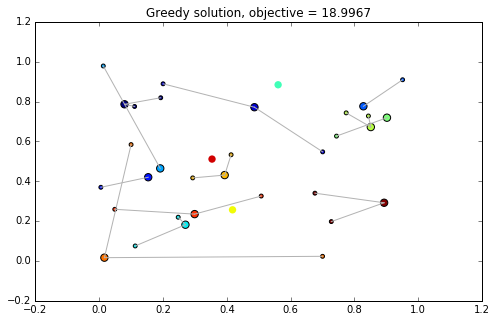

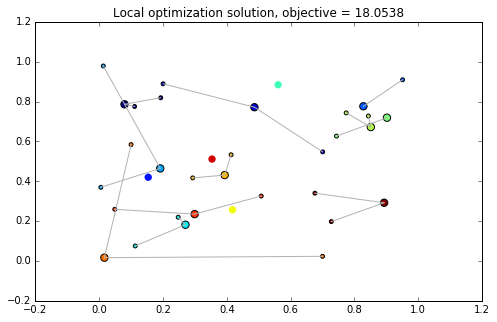

In [12]:
print('C = 15, F = 20')

# completely random solution
problem = random_problem(seed=666)
y, assignments = problem.solve_greedy()
problem.plot_solution(y, assignments, 'Greedy solution')

#gurobi solution
problem = random_problem(seed=666)
y, assignments = problem.solve_local_optimization()
problem.plot_solution(y, assignments, 'Local optimization solution')

C = 90, F = 10


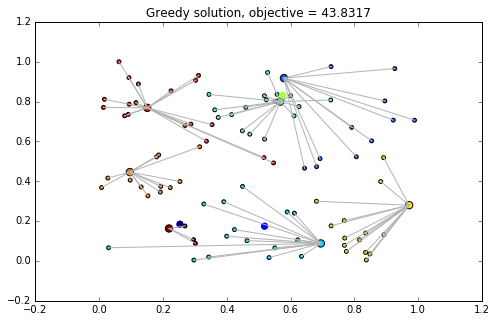

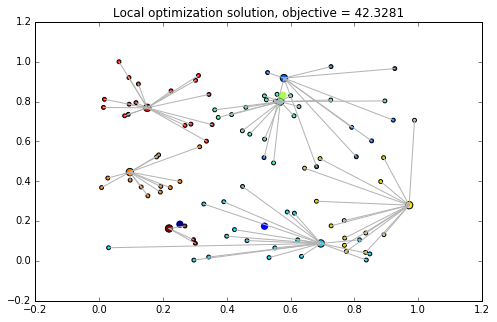

In [13]:
print('C = 90, F = 10')

problem = random_problem(seed=777, c=90, f=10)
y, assignments = problem.solve_greedy()
problem.plot_solution(y, assignments, 'Greedy solution')

problem = random_problem(seed=777, c=90, f=10)
y, assignments = problem.solve_local_optimization()
problem.plot_solution(y, assignments, 'Local optimization solution')

C = 20, F = 20


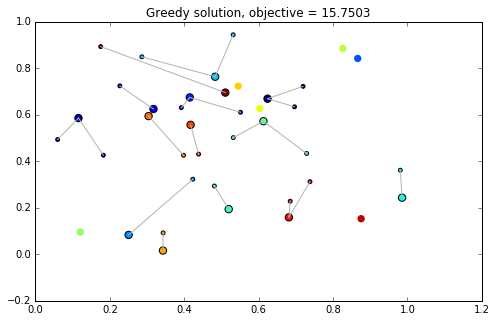

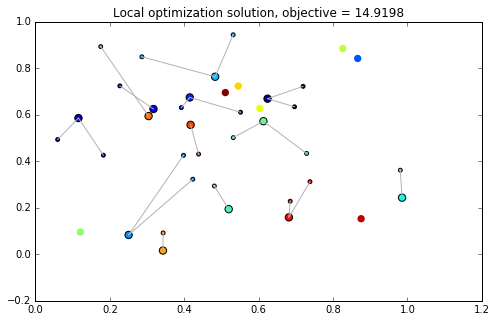

In [14]:
print('C = 20, F = 20')

problem = random_problem(seed=123, c=20, f=20)
y, assignments = problem.solve_greedy()
problem.plot_solution(y, assignments, 'Greedy solution')

problem = random_problem(seed=123, c=20, f=20)
y, assignments = problem.solve_local_optimization()
problem.plot_solution(y, assignments, 'Local optimization solution')

## Simulated annealing

There is realized simulated annealing algorithm as iw was given at our lectures. Realized temperature schedules are exponentional 'exp' and linear 'lin'.

In [15]:
def solve_simulated_annealing(self, max_iter=10000, T_0=1.5, gamma=0.95, schedule='exp'):
    # initial state
    y, assignments = self.solve_local_optimization()
    
    n_iter = 0
    y_best, assignments_best = deepcopy(y), deepcopy(assignments)
    best_f = self.objective(y_best, assignments_best)
    
    T = T_0
    
    if schedule == 'lin':
        max_iter=25000
        gamma = 0.1
        T_0 = 75
    
    while n_iter <= max_iter:
        # choose random neighbour (1 of 3 types)
        y_new, assignments_new = self.get_neighbour(y, assignments)
        new_f = self.objective(y_new, assignments_new)
        old_f = self.objective(y, assignments)
        dE = new_f - old_f
        
        if (dE < 0) or (np.exp((-dE/T)) > random.random()):
            y, assignments = y_new, assignments_new
            if self.objective(y, assignments) < best_f:
                y_best, assignments_best = deepcopy(y), deepcopy(assignments)
                best_f = self.objective(y_best, assignments_best)
                
        if schedule == 'exp':
            if n_iter%100 == 0:
                T = T*gamma
        elif schedule == 'lin':
            T = T_0/(1+gamma*n_iter)
        
        n_iter += 1
        
    return y_best, assignments_best
        
Problem.solve_simulated_annealing = solve_simulated_annealing

Demonstrations for several cases.

Because we decided to choose local optimization solution as an initial state, let's see if there are improvements.

C = 15, F = 20


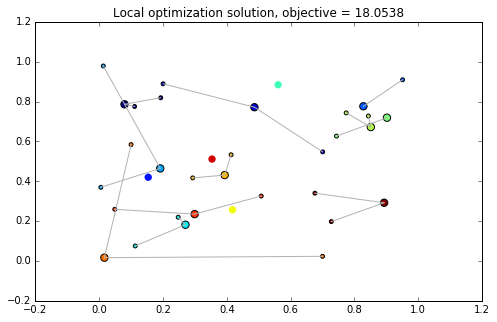

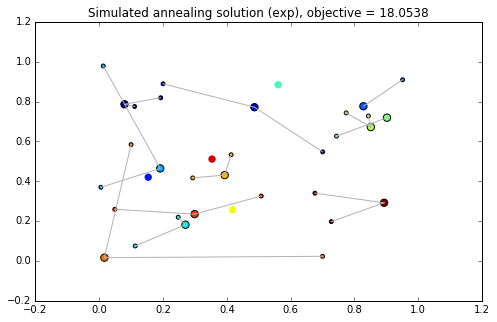

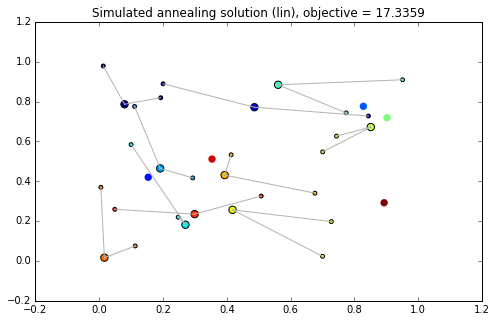

In [16]:
print('C = 15, F = 20')

problem = random_problem(seed=666)
y, assignments = problem.solve_local_optimization()
problem.plot_solution(y, assignments, 'Local optimization solution')

problem = random_problem(seed=666)
y, assignments = problem.solve_simulated_annealing(schedule='exp')
problem.plot_solution(y, assignments, 'Simulated annealing solution (exp)')

problem = random_problem(seed=666)
y, assignments = problem.solve_simulated_annealing(schedule='lin')
problem.plot_solution(y, assignments, 'Simulated annealing solution (lin)')

C = 90, F = 10


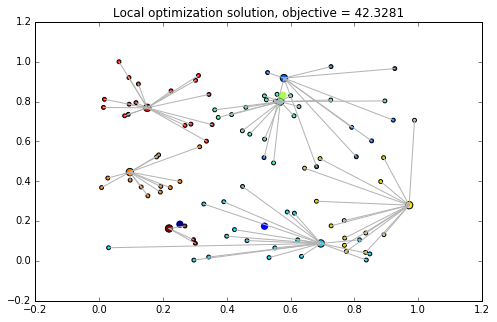

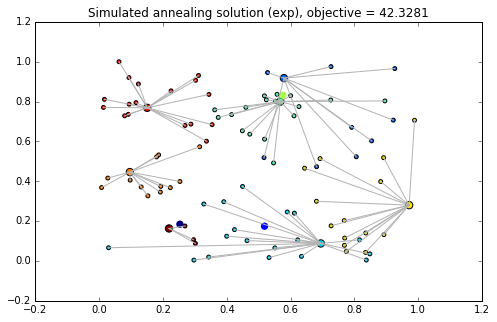

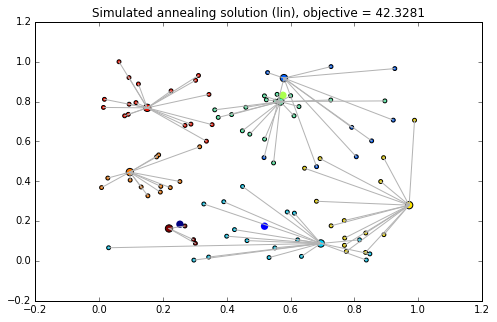

In [17]:
print('C = 90, F = 10')

problem = random_problem(seed=777, c=90, f=10)
y, assignments = problem.solve_local_optimization()
problem.plot_solution(y, assignments, 'Local optimization solution')

problem = random_problem(seed=777, c=90, f=10)
y, assignments = problem.solve_simulated_annealing(schedule='exp')
problem.plot_solution(y, assignments, 'Simulated annealing solution (exp)')

problem = random_problem(seed=777, c=90, f=10)
y, assignments = problem.solve_simulated_annealing(schedule='lin')
problem.plot_solution(y, assignments, 'Simulated annealing solution (lin)')

C = 20, F = 20


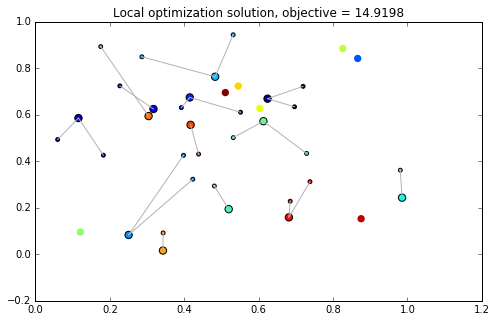

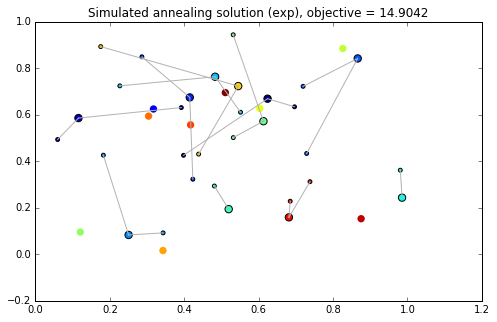

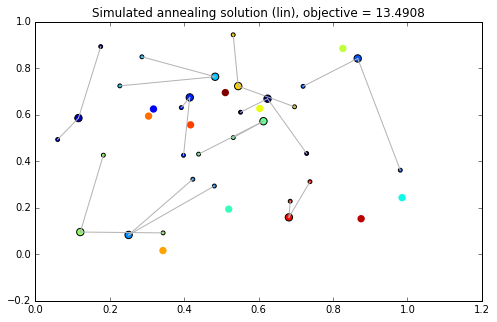

In [18]:
print('C = 20, F = 20')

problem = random_problem(seed=123, c=20, f=20)
y, assignments = problem.solve_local_optimization()
problem.plot_solution(y, assignments, 'Local optimization solution')

problem = random_problem(seed=123, c=20, f=20)
y, assignments = problem.solve_simulated_annealing(schedule='exp')
problem.plot_solution(y, assignments, 'Simulated annealing solution (exp)')

problem = random_problem(seed=123, c=20, f=20)
y, assignments = problem.solve_simulated_annealing(schedule='lin')
problem.plot_solution(y, assignments, 'Simulated annealing solution (lin)')

## Results comparison

In [30]:
# Suggested code for comparison (modify as needed)

def compare_results(problem, seed):
    fig = plt.figure(figsize=(15,9))

    ax_greedy = fig.add_subplot(221)
    ax_local  = fig.add_subplot(222)
    ax_anneal = fig.add_subplot(223)
    ax_gurobi = fig.add_subplot(224)

    np.random.seed(seed)
    greedy = problem.solve_greedy()
    np.random.seed(seed)
    local  = problem.solve_local_optimization()
    np.random.seed(seed)
    gurobi = problem.solve_gurobi()
    np.random.seed(seed)    
    anneal = problem.solve_simulated_annealing(schedule='lin')

    ax_greedy.set_title('Greedy:    %.3f' % problem.objective(*greedy))
    ax_local .set_title('Local:     %.3f' % problem.objective(*local))
    ax_anneal.set_title('Annealing (lin): %.3f' % problem.objective(*anneal))
    ax_gurobi.set_title('Gurobi:    %.3f' % problem.objective(*gurobi))

    problem.plot(greedy[0], greedy[1], ax_greedy)
    problem.plot(local [0], local [1], ax_local )
    problem.plot(anneal[0], anneal[1], ax_anneal)
    problem.plot(gurobi[0], gurobi[1], ax_gurobi)

    for ax in ax_greedy, ax_local, ax_anneal, ax_gurobi:
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

C = 100, F = 100


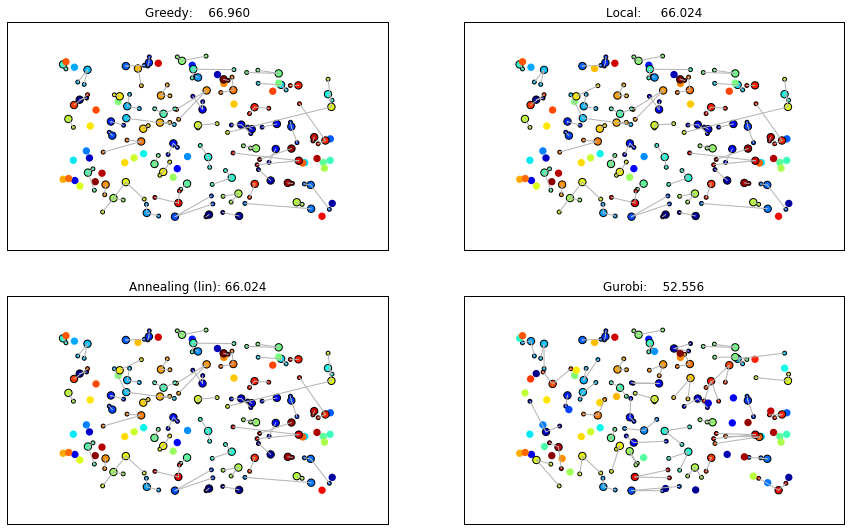

In [31]:
problem = random_problem(seed=123, c=100, f=100)
print('C = 100, F = 100')
compare_results(problem, seed=123)

C = 100, F = 8


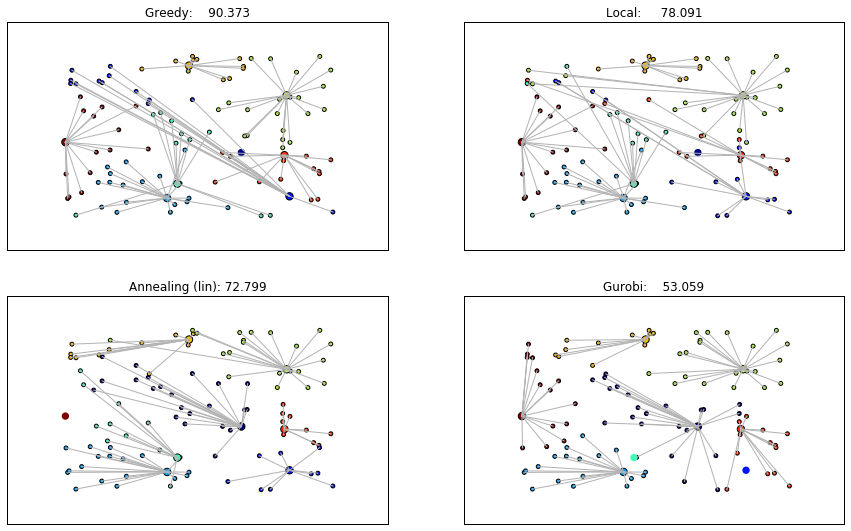

In [32]:
problem = random_problem(seed=111, c=100, f=8)
print('C = 100, F = 8')
compare_results(problem, seed=111)

C = 50, F = 10


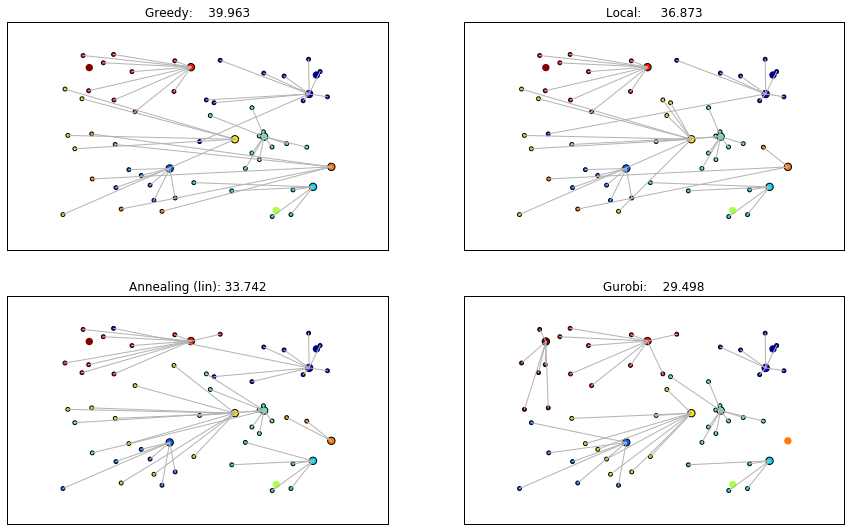

In [33]:
problem = random_problem(seed=666, c=50, f=10)
print('C = 50, F = 10')
compare_results(problem, seed=666)

# Problem 2
**Optimal vehicle speed scheduling (6 points)** -- (based on an additional exercise A3.20 to Boyd and Vandenberghe). 

A vehicle (say, an airplane) travels along a fixed path of $n$ segments, between $n + 1$ waypoints labeled $0, \dots , n$. Segment $i$ starts at waypoint $i-1$ and terminates at waypoint $i$. The vehicle starts at time $t = 0$ at waypoint $0$. It travels over each segment at a constant (nonnegative) speed; $s_i$ is the speed on segment $i$. We have lower and upper limits on the speeds: $s_{\min} \leq s \leq s_{\max}$. The vehicle does not stop at the waypoints; it simply proceeds to the next segment. The travel distance of segment $i$ is $d_i$ (which is positive), so the travel time over segment $i$ is $\frac{d_i}{s_i}$. We let $\tau_i$, $i = 1, \dots, n$ denote the time at which the vehicle arrives at waypoint $i$. The vehicle is required to arrive at waypoint $i$, $i = 1, \dots, n$, between times $\tau_{\min,i}$ and $\tau_{\max,i}$, which are given. The vehicle consumes fuel over segment $i$ at a rate that depends on its speed $\Phi\left(s_i\right) = a s_i^2+b s_i+c$ kg/s.

You are given the data $d$ (segment travel distances), $s_{\min}$ and $s_{\max}$ (speed bounds), $\tau_{\min}$ and $\tau_{\max}$ (waypoint arrival time bounds), and parameters $a$, $b$, and $c$ (all parameters are in *veh_speed_sched_data.m*). Use the dynamic programming approach to find the schedule that allows spending the minimal amount of fuel. Use matplotlib command *step* to plot speed vs time for the optimal schedule. You will need to discretize some continuous variables, make sure you do it densely enough.

**NB**: later in the course we will get back to this problem and attack it with a different method.


#### Solution

Usually as a result of dynamic programming we get a table of objective function values. Our table will be constructed in the following way:

1st index corresponds to path segment index $j = 0,\dots,n-1$, 2nd index corresponds to time division segment index $k = 0,1,\dots,n_{div}=m$, s.t. $tau\_min[j] = t_{j_0} < t_{j_1} < \dots < t_{j_m} = tau\_max[j]$

On each step $j,k$ we construct value of $table[j][k]$:

$table[j][k] = \min_{k\_p}\big( table[j-1][k\_p] + \Phi(\frac{d[k]}{t_k - t_{k\_p}})(t_k - t_{k\_p}) \big)$, where $t_{k\_p} < t_k$

$table[0][k] = \Phi(t_k)*t_k$

Then the minimum amount of fuel we need would be equal $\min_{k}table[n-1][k]$

In [23]:
import scipy.io as sio

class Vehicle:
    
    def __init__(self, contents_path='veh_sched_data.mat'):
        self.mat_contents = sio.loadmat('veh_sched_data.mat')
        self.a = self.mat_contents['a'][0,0]
        self.b = self.mat_contents['b'][0,0]
        self.c = self.mat_contents['c'][0,0]
        self.d = self.mat_contents['d'].squeeze()
        self.n = self.mat_contents['n'][0,0]
        self.smin = self.mat_contents['smin'].squeeze()
        self.smax = self.mat_contents['smax'].squeeze()
        self.tau_min = self.mat_contents['tau_min'].squeeze()
        self.tau_max = self.mat_contents['tau_max'].squeeze()
      
    # fuel function on the segment
    def partial_objective(self, s_i, i):
        if self.smin[i] > s_i:
            return np.inf
        if self.smax[i] < s_i:
            return np.inf
        return self.a*s_i**2 + self.b*s_i + self.c

In [24]:
def dynamic_programming(self):
    n_divide = 100
    
    table = np.zeros((self.n, n_divide + 1))
    
    # table for times (as described above)
    times = np.zeros((self.n, n_divide + 1))
    for j in range(self.n):
        t_max = self.tau_max[j]
        t_min = self.tau_min[j]
        delta = (t_max - t_min)/n_divide
        for k in range(n_divide + 1):
            times[j][k] = t_min + k*delta
        
    # table for speeds corresponding to the main table results
    speeds = np.zeros((self.n, n_divide + 1))
        
    # table for traceback
    traceback = np.zeros((self.n, n_divide + 1), dtype=np.int32)
    
    # schedule array
    schedule = np.zeros(self.n)
    
    # j is segment index
    # k is index of [tau_min, tau_max] division
    for j in range(self.n):
        for k in range(n_divide + 1):
            # first row is simple
            if j == 0:
                speeds[j][k] = self.d[j]/times[j][k]
                table[j][k] = self.partial_objective(speeds[j][k], j)*times[j][k]
            else:
                # previous times such that less than the current time
                prev_k = [i for i in range(n_divide + 1) if times[j-1][i] < times[j][k]]
                
                # let's find the best one to fill the main table
                best_prev_k = 0
                best_objective_prev = np.inf
                for p_k in prev_k:
                    # we want to minimize total objective
                    speeds[j][k] = self.d[j]/(times[j][k]-times[j-1][p_k])
                    current_objective = table[j-1][p_k] + self.partial_objective(speeds[j][k], j)*(times[j][k]-times[j-1][p_k])
                    if current_objective < best_objective_prev:
                        best_objective_prev = current_objective
                        best_prev_k = p_k
                speeds[j][k] = self.d[j]/(times[j][k]-times[j-1][best_prev_k])
                table[j][k] = best_objective_prev
                traceback[j][k] = best_prev_k
                
    # find the schedule
    min_objective = table[self.n-1][0]
    min_ind = 0
    for k in range(0, n_divide + 1):
        if table[self.n-1][k] < min_objective:
            min_ind = k
    schedule[self.n-1] = speeds[self.n-1][min_ind]
    
    prev_ind = traceback[self.n-1][min_ind]
    for j in range(self.n-1, 0, -1):
        schedule[j-1] = speeds[j][prev_ind]
        prev_ind = traceback[j][prev_ind]
    
    return table, schedule

Vehicle.dynamic_programming = dynamic_programming

In [25]:
def objective(self):
    table, all_speeds = self.dynamic_programming()
    return min(table[vehicle.n-1])

Vehicle.objective = objective

In [26]:
def schedule_plot(self, schedule):
    times = [0]
    for i in range(self.n):
        times.append(times[-1] + self.d[i]/schedule[i])
    times = times[1:]
    
    plt.figure(figsize=(12,5))
    plt.step(times, schedule)
    plt.xlabel("Time")
    plt.ylabel("Speed")
    plt.show()

Vehicle.schedule_plot = schedule_plot

In [27]:
vehicle = Vehicle()
table, schedule = vehicle.dynamic_programming()
objective = vehicle.objective()

In [28]:
print ('The smaller amount of fuel we need is', objective)

The smaller amount of fuel we need is 2617.92938583


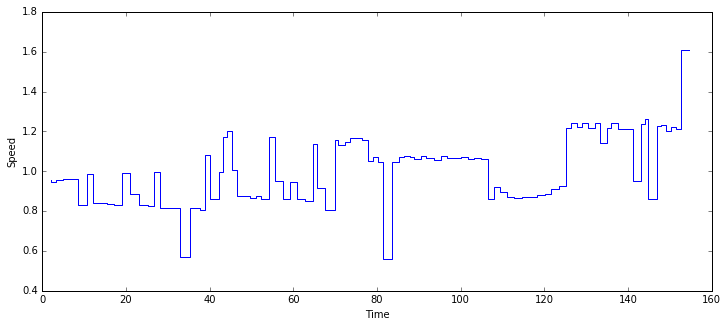

In [29]:
vehicle.schedule_plot(schedule)